In [17]:
import pandas as pd
import os
import glob

# 设置智联招聘数据所在的文件夹
folder_path = ".\\zlzp"
# 获取文件夹中所有城市子目录
city_folders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

print(f"找到城市文件夹：{city_folders}")

df_list = []

# 遍历每个城市文件夹
for city in city_folders:
    city_path = os.path.join(folder_path, city)
    # 查找该城市目录下的所有Excel文件
    excel_files = glob.glob(os.path.join(city_path, "*.xlsx"))
    
    print(f"正在读取 {city}：找到 {len(excel_files)} 个文件")
    
    # 逐个读取Excel文件
    for filename in excel_files:
        try:
            temp_df = pd.read_excel(filename)
            # 添加城市列以标记数据来源
            temp_df['source_city'] = city
            df_list.append(temp_df)
            print(f"  ✓ {os.path.basename(filename)}")
        except Exception as e:
            print(f"  ✗ 读取 {filename} 失败: {e}")

# 合并所有城市数据
if len(df_list) > 0:
    df_zl = pd.concat(df_list, ignore_index=True)
    print(f"\n成功合并 {len(df_list)} 个文件，共 {len(df_zl)} 条数据")
    print(f"包含城市：{df_zl['source_city'].unique()}")
else:
    print("未找到任何 Excel 文件，请检查路径")


找到城市文件夹：['上海', '北京', '南京', '广州', '杭州', '深圳']
正在读取 上海：找到 12 个文件
  ✓ 产品_上海.xlsx
  ✓ 保险_上海.xlsx
  ✓ 咨询_上海.xlsx
  ✓ 商业分析_上海.xlsx
  ✓ 基金_上海.xlsx
  ✓ 投行_上海.xlsx
  ✓ 数据分析_上海.xlsx
  ✓ 证券_上海.xlsx
  ✓ 财务_上海.xlsx
  ✓ 咨询_上海.xlsx
  ✓ 商业分析_上海.xlsx
  ✓ 基金_上海.xlsx
  ✓ 投行_上海.xlsx
  ✓ 数据分析_上海.xlsx
  ✓ 证券_上海.xlsx
  ✓ 财务_上海.xlsx
  ✓ 运营_上海.xlsx
  ✓ 量化_上海.xlsx
  ✓ 银行_上海.xlsx
正在读取 北京：找到 12 个文件
  ✓ 产品_北京.xlsx
  ✓ 保险_北京.xlsx
  ✓ 运营_上海.xlsx
  ✓ 量化_上海.xlsx
  ✓ 银行_上海.xlsx
正在读取 北京：找到 12 个文件
  ✓ 产品_北京.xlsx
  ✓ 保险_北京.xlsx
  ✓ 咨询_北京.xlsx
  ✓ 商业分析_北京.xlsx
  ✓ 基金_北京.xlsx
  ✓ 投行_北京.xlsx
  ✓ 数据分析_北京.xlsx
  ✓ 证券_北京.xlsx
  ✓ 咨询_北京.xlsx
  ✓ 商业分析_北京.xlsx
  ✓ 基金_北京.xlsx
  ✓ 投行_北京.xlsx
  ✓ 数据分析_北京.xlsx
  ✓ 证券_北京.xlsx
  ✓ 财务_北京.xlsx
  ✓ 运营_北京.xlsx
  ✓ 量化_北京.xlsx
  ✓ 银行_北京.xlsx
正在读取 南京：找到 5 个文件
  ✓ 产品_南京.xlsx
  ✓ 财务_北京.xlsx
  ✓ 运营_北京.xlsx
  ✓ 量化_北京.xlsx
  ✓ 银行_北京.xlsx
正在读取 南京：找到 5 个文件
  ✓ 产品_南京.xlsx
  ✓ 基金_南京.xlsx
  ✓ 财务_南京.xlsx
  ✓ 运营_南京.xlsx
  ✓ 基金_南京.xlsx
  ✓ 财务_南京.xlsx
  ✓ 运营_南京.xlsx
  ✓ 银行_南京.xlsx
正在读取 广州：找到 10 个文件
  ✓ 产品_广

In [18]:
import re

# 清洗智联招聘的薪资数据，提取平均月薪（单位：K）
def clean_zl_salary(s):
    s = str(s)
    # 如果是"面议"或空值则返回None
    if '面议' in s or pd.isna(s):
        return None
    
    try:
        # 用正则表达式提取所有数字
        nums = re.findall(r'\d+\.?\d*', s)
        if len(nums) < 2:
            return None
        low, high = float(nums[0]), float(nums[1])
        
        # 判断单位：万元、千元或默认情况
        if '万' in s:
            return (low + high) / 2 * 10  # 万元转换为K
        elif '千' in s:
            return (low + high) / 2  # 千元即为K
        else:
            # 根据数值大小判断单位
            if low > 100:
                return (low + high) / 2 / 1000  # 假设为元，转换为K
            else:
                return (low + high) / 2
    except:
        return None

# 从城市字符串中提取主城市名（去除区域后缀）
def get_city(s):
    if pd.isna(s):
        return '未知'
    return s.split('·')[0]

# 从岗位要求中提取学历或经验要求
def split_req(s, type_='edu'):
    s = str(s)
    edus = ['大专', '本科', '硕士', '博士', '学历不限', '中专', '高中']
    
    # 提取学历信息
    for e in edus:
        if e in s and type_ == 'edu':
            return e
    
    # 提取经验信息（去除学历关键词后的剩余部分）
    if type_ == 'exp':
        for e in edus:
            s = s.replace(e, '').replace(',', '').replace('，', '')
        return s.strip()
    return '未知'

# 根据岗位名称分类岗位类型
def categorize_job_zl(title):
    t = str(title).lower()
    # 保险类岗位
    if any(x in t for x in ['保险', '核保', '理赔', '精算', '查勘']):
        return '保险'
    # 财务类岗位
    if any(x in t for x in ['财务', '会计', '审计', '出纳', '税务']):
        return '财务'
    # 产品类岗位
    if any(x in t for x in ['产品', '策划']):
        return '产品'
    # 基金类岗位
    if any(x in t for x in ['基金']):
        return '基金'
    # 量化交易岗位
    if any(x in t for x in ['量化', '算法', '策略']):
        return '量化'
    # 证券交易岗位
    if any(x in t for x in ['证券', '股票', '交易员']):
        return '证券'
    # 银行岗位
    if any(x in t for x in ['银行', '柜员', '信贷']):
        return '银行'
    # 投行岗位
    if any(x in t for x in ['投行', '保荐', '承销']):
        return '投行'
    # 商业/数据分析岗位
    if any(x in t for x in ['商业分析', '数据分析', 'bi', 'ba', '分析师']):
        return '商业/数据分析'
    # 运营岗位
    if any(x in t for x in ['运营', '新媒体', '电商']):
        return '运营'
    # 咨询岗位
    if any(x in t for x in ['咨询', '顾问', '猎头']):
        return '咨询'
    return '其他'

# 应用各个清洗函数
df_zl['avg_salary'] = df_zl['岗位薪资'].apply(clean_zl_salary)
df_zl['city'] = df_zl['公司位置'].apply(get_city)
df_zl['job_type'] = df_zl['岗位名称'].apply(categorize_job_zl)
df_zl['education'] = df_zl['岗位要求'].apply(lambda x: split_req(x, 'edu'))

# 删除薪资缺失的记录
df_clean = df_zl.dropna(subset=['avg_salary'])
print("清洗完成！")


清洗完成！


清洗完成！剩余有效数据：21906 条


C:\Users\xixif\AppData\Local\Temp\ipykernel_17380\2217443324.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')


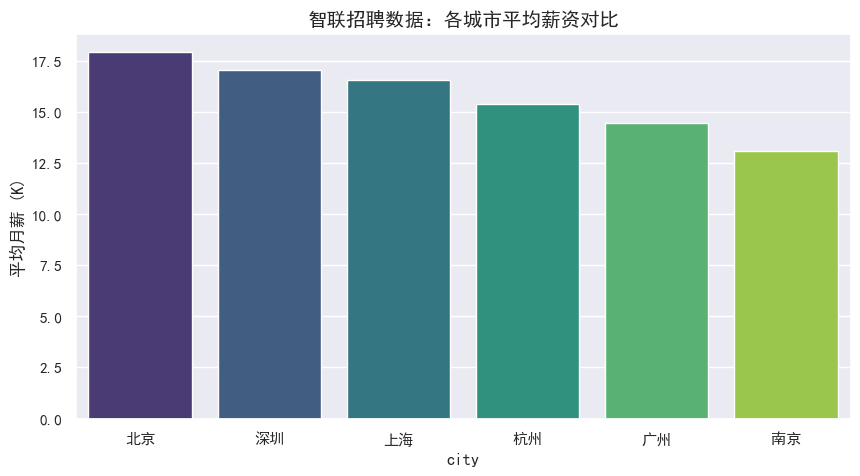

C:\Users\xixif\AppData\Local\Temp\ipykernel_17380\2217443324.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')


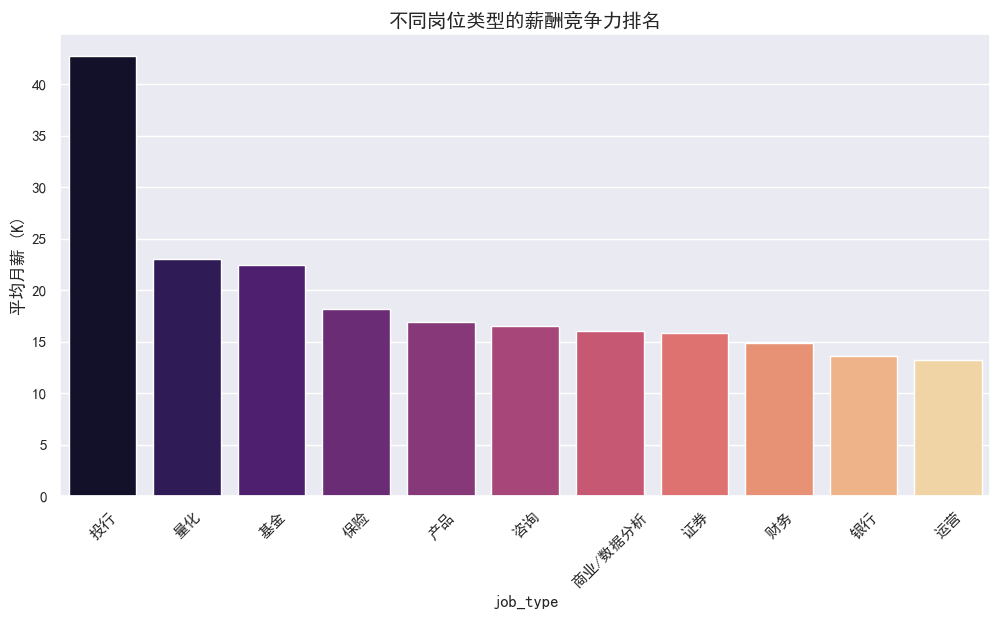

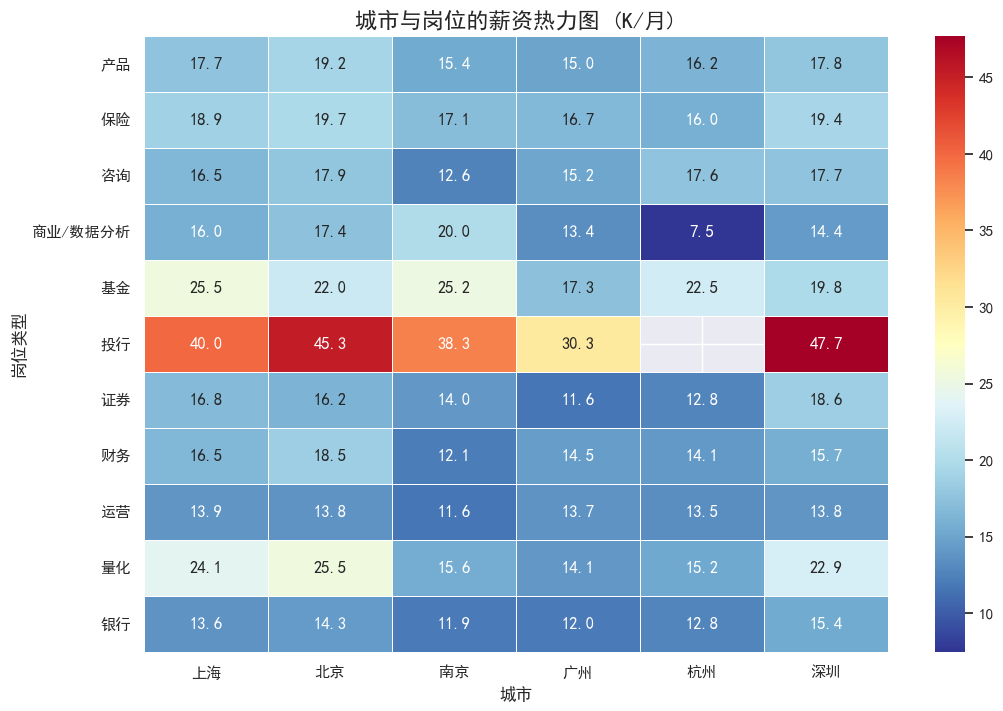

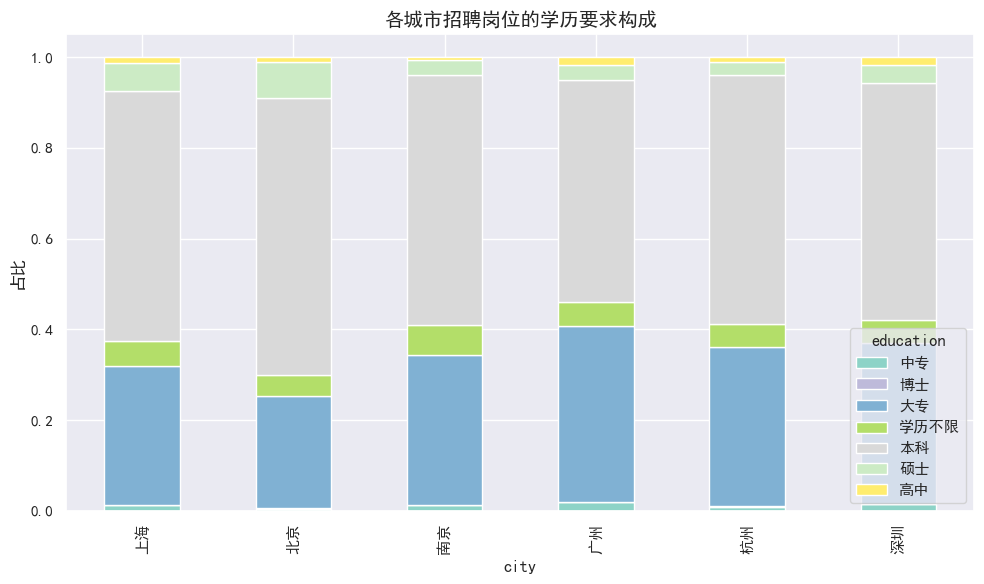

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定义需要过滤的无效值列表
dirty_words = ['暂无', '未知', 'None', '其他', '不限']

# 进一步清洗数据：移除无效的城市、学历和岗位类型
df_clean = df_clean[~df_clean['city'].isin(dirty_words)]
df_clean = df_clean[~df_clean['education'].isin(dirty_words)]
df_clean = df_clean[df_clean['job_type'] != '其他']
df_clean = df_clean.dropna(subset=['city', 'education', 'job_type'])

print(f"清洗完成！剩余有效数据：{len(df_clean)} 条")

# 配置绘图风格
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建保存图片的文件夹
os.makedirs('./website/data/picture', exist_ok=True)

# 【图1】城市薪资对比：计算各城市的平均月薪并排序
city_salary = df_clean.groupby('city')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')
plt.title('智联招聘数据：各城市平均薪资对比', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.savefig('./website/data/picture/zlzp城市平均薪资对比.png', dpi=300, bbox_inches='tight')
plt.show()

# 【图2】岗位薪资排名：计算不同岗位类型的平均薪资
core_jobs = df_clean[df_clean['job_type'] != '其他']
job_salary = core_jobs.groupby('job_type')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')
plt.title('不同岗位类型的薪酬竞争力排名', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.xticks(rotation=45)
plt.savefig('./website/data/picture/zlzp岗位类型薪酬排名.png', dpi=300, bbox_inches='tight')
plt.show()

# 【图3】热力图：城市与岗位的薪资交叉分析
pivot_data = core_jobs.pivot_table(index='job_type', columns='city', values='avg_salary', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap='RdYlBu_r', linewidths=0.5)
plt.title('城市与岗位的薪资热力图 (K/月)', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('岗位类型', fontsize=12)
plt.savefig('./website/data/picture/zlzp城市岗位薪资热力图.png', dpi=300, bbox_inches='tight')
plt.show()

# 【图4】堆积柱状图：各城市的学历要求构成
edu_city = pd.crosstab(df_clean['city'], df_clean['education'])
# 转换为百分比形式
edu_city_pct = edu_city.div(edu_city.sum(1), axis=0)

edu_city_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('各城市招聘岗位的学历要求构成', fontsize=14)
plt.ylabel('占比', fontsize=12)
plt.tight_layout()
plt.savefig('./website/data/picture/zlzp城市学历要求构成.png', dpi=300, bbox_inches='tight')
plt.show()






C:\Users\xixif\AppData\Local\Temp\ipykernel_17380\1958396508.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


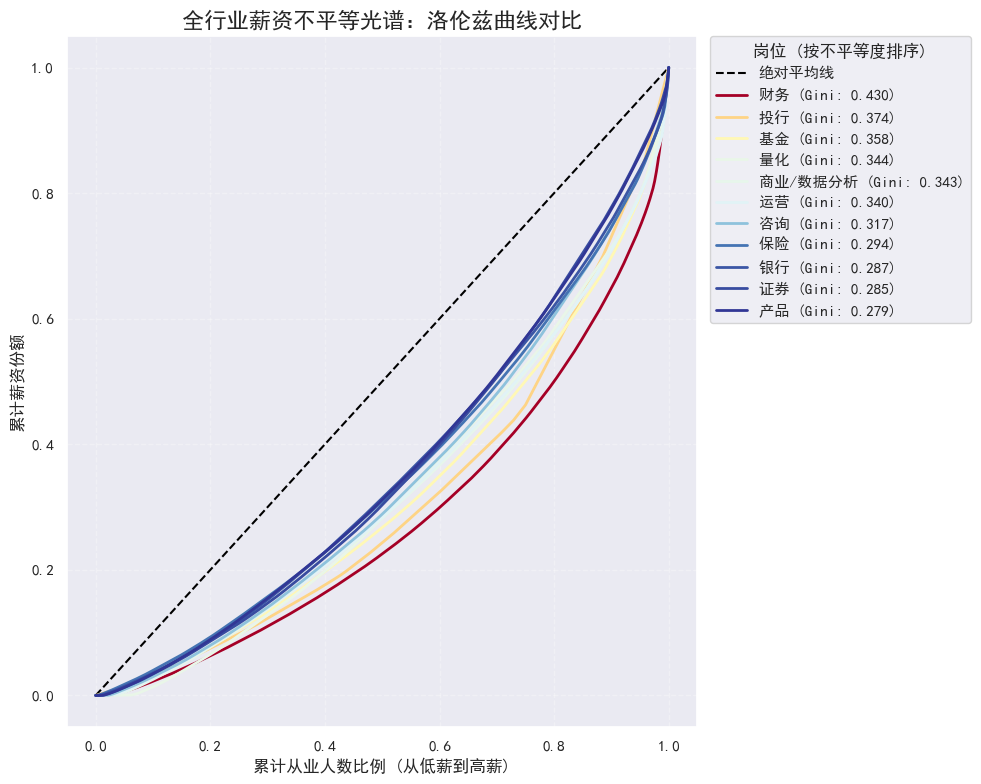

------ 岗位薪资不平等度排名 (从高到低) ------
         岗位      Gini
0        财务  0.430278
1        投行  0.373583
2        基金  0.357981
3        量化  0.343889
4   商业/数据分析  0.343291
5        运营  0.340465
6        咨询  0.316617
7        保险  0.294005
8        银行  0.287205
9        证券  0.284945
10       产品  0.279159


In [20]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from matplotlib import cm

# 配置中文字体和绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set(font='SimHei')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# 计算薪资不平等指数（基尼系数）
job_types = df_clean['job_type'].unique()
gini_data = []

# 基尼系数计算函数：用于衡量薪资分布的不平等程度
def calculate_gini(x):
    x = np.array(x, dtype=np.float64)
    # 检查数据有效性
    if np.any(x < 0): 
        return 0
    if len(x) == 0: 
        return 0
    # 按薪资排序
    sorted_x = np.sort(x)
    n = len(x)
    # 计算累计薪资
    cumx = np.cumsum(sorted_x, dtype=np.float64)
    # 计算基尼系数（0-1之间，越接近0表示越平等）
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# 为每个岗位类型计算基尼系数
for job in job_types:
    if job == '其他': 
        continue
    salaries = df_clean[df_clean['job_type'] == job]['avg_salary'].values
    # 样本量要求最少10个
    if len(salaries) > 10:
        g = calculate_gini(salaries)
        gini_data.append({'岗位': job, 'Gini': g})

gini_df = pd.DataFrame(gini_data).sort_values('Gini', ascending=False)

# 绘制洛伦兹曲线：直观展示薪资分布的不平等程度
plt.figure(figsize=(10, 8))
# 绝对平等线（参考线）
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1.5, label='绝对平均线')

# 根据基尼系数的大小配置颜色
norm = plt.Normalize(gini_df['Gini'].min(), gini_df['Gini'].max())
cmap = cm.get_cmap('RdYlBu_r')

# 为每个岗位绘制洛伦兹曲线
for idx, row in gini_df.iterrows():
    job_name = row['岗位']
    gini_val = row['Gini']
    # 获取该岗位的所有薪资数据并排序
    salaries = np.sort(df_clean[df_clean['job_type'] == job_name]['avg_salary'].values)
    # 计算累计薪资占比
    y = np.cumsum(salaries) / salaries.sum()
    y = np.insert(y, 0, 0)  # 起点为(0,0)
    x = np.linspace(0, 1, len(y))  # 从业人数累计占比
    # 根据基尼系数大小决定颜色
    color = cmap(norm(gini_val))
    plt.plot(x, y, color=color, linewidth=2, label=f"{job_name} (Gini: {gini_val:.3f})")

plt.title('全行业薪资不平等光谱：洛伦兹曲线对比', fontsize=16)
plt.xlabel('累计从业人数比例 (从低薪到高薪)', fontsize=12)
plt.ylabel('累计薪资份额', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="岗位 (按不平等度排序)")
plt.tight_layout()
plt.savefig('./website/data/picture/zlzp薪资不平等洛伦兹曲线.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出岗位薪资不平等度排名结果
print("------ 岗位薪资不平等度排名 (从高到低) ------")
print(gini_df.reset_index(drop=True))
